In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from string import ascii_uppercase

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5,)


import numpy as np
import pandas as pd
import xarray as xr

In [2]:
ds_hr = xr.open_dataset('/raid2/jhamman/projects/RASM/data/RVIC/dai2006-1.1.0.b/temp/aggregated/aggUH_Mackenzie_at_Arctic_Red.nc')
ds_rm = xr.open_dataset('/raid2/jhamman/projects/RASM/data/RVIC/dai2006-1.1.0.b/temp/remapped/remapUH_Mackenzie_at_Arctic_Red.nc')
df_box = pd.read_csv('../data/UH_RASM_hourly.csv')

In [3]:
plt_kwargs = dict(levels=10, vmin=0, vmax=0.15, cmap='viridis_r', extend='max', add_colorbar=False, zorder=10)

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


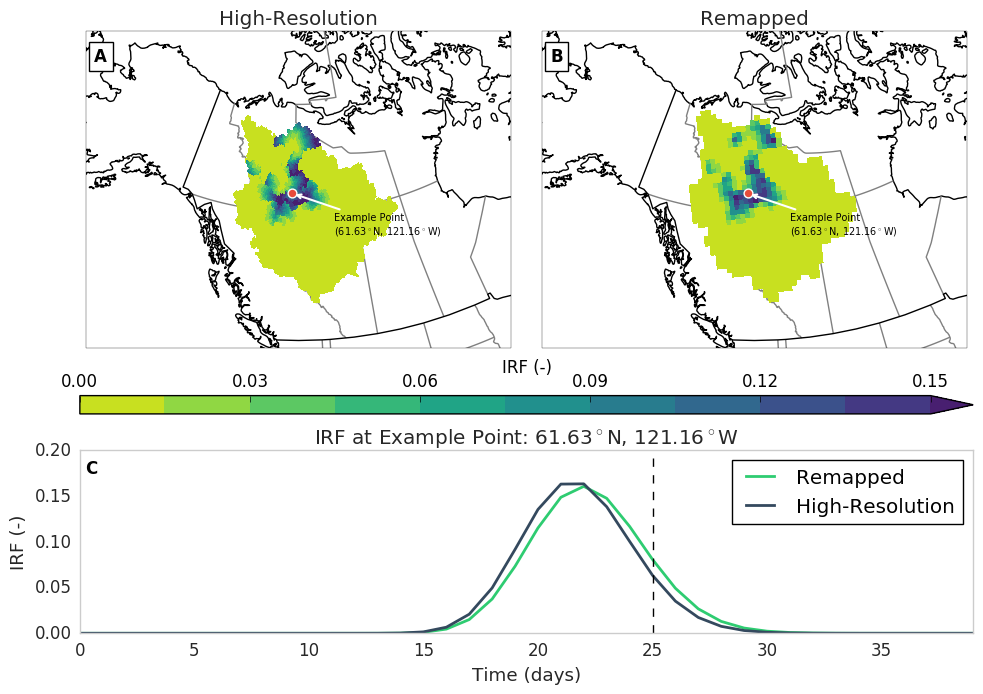

In [4]:
ts = 25
vmax = ymax = 0.2

fig = plt.figure(figsize=(10, 7)) 
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1.5])
ax1 = plt.subplot(gs[0, 0], projection=ccrs.NorthPolarStereo(-120))
ax2 = plt.subplot(gs[0, 1], projection=ccrs.NorthPolarStereo(-120))
ax3 = plt.subplot(gs[1, :])

ds_hr.unit_hydrograph.isel(timesteps=ts).where(ds_hr.fraction).plot(
    ax=ax1, transform=ccrs.PlateCarree(), **plt_kwargs)
ax1.set_title('High-Resolution')
mappable = ds_rm.unit_hydrograph.isel(
    timesteps=ts, x=slice(130, 180), y=slice(15, 65)).where(ds_rm.fraction).plot(
        x='xc', y='yc', transform=ccrs.PlateCarree(), ax=ax2, **plt_kwargs)
ax2.set_title('Remapped')

# colorbar
divider = make_axes_locatable(ax3)
cax = divider.append_axes("top", "10%", pad="20%")
cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar.set_label('IRF (-)', labelpad=-40, rotation=0)
cbar.ax.xaxis.set_ticks_position('top')

da_point = ds_rm.unit_hydrograph.isel(x=150, y=40)
uh = da_point.to_series()
uh.index = np.arange(len(uh))
uh.plot(ax=ax3, label='Remapped', lw=2, c='#2ecc71')

lon, lat = da_point.xc - 360, da_point.yc

uh = ds_hr.unit_hydrograph.sel(lon=lon, lat=lat, tolerance=0.25, method='nearest').to_series()
uh.plot(ax=ax3, label='High-Resolution', lw=2, c='#34495e')
ax3.legend()
ax3.plot([ts, ts], [0, vmax], 'k--')
ax3.set_ylim(top=ymax)
ax3.set_title('IRF at Example Point: %.2f$^\circ$N, %.2f$^\circ$W' % (lat, -1*lon))
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('IRF (-)')

for ax in [ax1, ax2]:
    ax.coastlines(lw=1, resolution='50m')
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='white')
    
    ax.add_feature(states_provinces, facecolor='none', edgecolor='gray', zorder=1)
    ax.add_feature(cfeature.BORDERS, zorder=2)
    ax.set_extent([-145, -95, 45, 75], ccrs.Geodetic())
    ax.scatter(da_point.xc - 360, da_point.yc, transform=ccrs.PlateCarree(), color='#e74c3c', edgecolor='white', s=40, zorder=11)
    
#     ax.annotate('local max', xy=(da_point.xc - 360, da_point.yc), xytext=(da_point.xc - 360 + 2, da_point.yc - 2),
#                 arrowprops=dict(facecolor='black', shrink=0.05),
#                 transform=ccrs.PlateCarree(), zorder=30)
    # NOTE: the "plt.annotate call" does not have a "transform=" keyword,
    # so for this one we transform the coordinates with a Cartopy call.
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.PlateCarree())
    plt.sca(ax)
    plt.annotate(
        'Example Point\n(%.2f$^\circ$N, %.2f$^\circ$W)' % (lat, -1*lon), xy=(at_x, at_y), xytext=(30, -30), textcoords='offset points',
        color='black', backgroundcolor='none', size=7,
        arrowprops=dict(arrowstyle='->', color='white', linewidth=1.5), zorder=30)  

for i, ax in enumerate([ax1, ax2, ax3]):
    if i == 2:
        x, y = 0.02, 0.95
    else:
        x, y = 0.05, 0.95
       
    t = ax.text(x, y,
            ascii_uppercase[i],
            transform=ax.transAxes,
            fontsize=12, fontweight='semibold', va='top', ha='right')
    if i < 2:
        t.set_bbox(dict(alpha=1, facecolor='white', edgecolor='k', lw=1))
fig.tight_layout()
# fig.suptitle('Mackenzie River Unit Hydrographs', fontweight='semibold', y=1.02, x=0.55)

fig.savefig('../figs/uh_remap_schematic.png', dpi=300)

In [5]:
print(da_point.xc.values - 360, da_point.yc.values)

-121.162779823 61.62818479481822
